# Online Retails Purchase

### Introduction:



### Step 1. Import the necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as t
import requests
import os

In [2]:
os.chdir('/tf/pyspark_exercises/07_Visualization/Online_Retail/')


### Step 2. Import the dataset from this [address](https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/07_Visualization/Online_Retail/Online_Retail.csv). 

### Step 3. Assign it to a variable called online_rt
Note: if you receive a utf-8 decode error, set `encoding = 'latin1'` in `pd.read_csv()`.

In [3]:
spark = SparkSession.builder\
                    .appName('retail')\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 18:07:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
url = 'https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/07_Visualization/Online_Retail/Online_Retail.csv'

get_url = requests.get(url)

with open('data.csv', 'w', encoding='utf-8') as f:
    f.writelines(get_url.text)



In [5]:
online_rt = spark.read.csv('data.csv', sep=',', header=True)

In [6]:
online_rt.show()

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/10 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/10 8:26|     4.25|     17850|United

In [7]:
df = pd.read_csv('data.csv', sep=',', header=0)

### Step 4. Create a histogram with the 10 countries that have the most 'Quantity' ordered except UK

In [8]:
online_rt.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [16]:
from pyspark.sql import types as T
online_rt = online_rt.withColumn('Quantity', F.trim(F.col('Quantity'))\
                                              .cast(T.IntegerType()))

In [23]:
all_country_except_uk = online_rt.filter(F.col('Country') != 'United Kingdom')

top_10 = all_country_except_uk.groupBy('Country').agg(F.sum('Quantity').alias('Cantidad total ordenada')).orderBy(F.col('Cantidad total ordenada'), ascending=False).limit(10)

top_10.show()

+-----------+-----------------------+
|    Country|Cantidad total ordenada|
+-----------+-----------------------+
|Netherlands|                 200128|
|       EIRE|                 142637|
|    Germany|                 117448|
|     France|                 110480|
|  Australia|                  83653|
|     Sweden|                  35637|
|Switzerland|                  30325|
|      Spain|                  26824|
|      Japan|                  25218|
|    Belgium|                  23152|
+-----------+-----------------------+



In [25]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [26]:
df['Quantity'] = df['Quantity'].astype(int)

In [36]:
df_filtrado = df[df['Country'] != 'United Kingdom']
top_10_df = df_filtrado.groupby(['Country'], as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False).head(10)

top_10_df

,Country,Quantity
24,Netherlands,200128
10,EIRE,142637
14,Germany,117448
13,France,110480
0,Australia,83653
32,Sweden,35637
33,Switzerland,30325
31,Spain,26824
20,Japan,25218
3,Belgium,23152


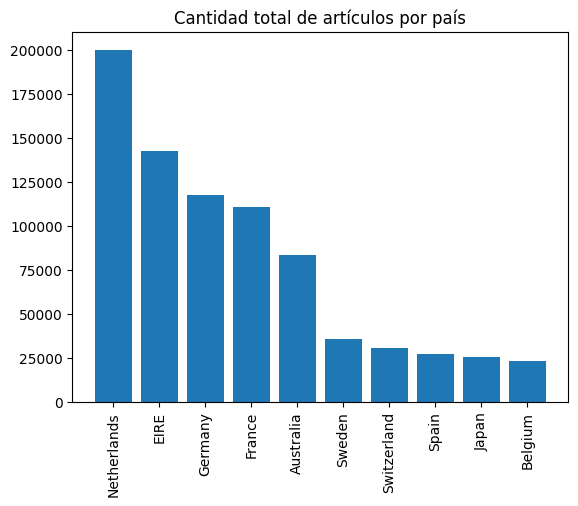

In [43]:
plt.bar(x= top_10_df['Country'], height=top_10_df['Quantity'])
plt.xticks(rotation=90)
plt.title('Cantidad total de artículos por país')
plt.show()

### Step 5.  Exclude negative Quantity entries

In [47]:
online_rt = online_rt.filter(F.col('Quantity')>=0)

In [48]:
online_rt.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 5 rows



In [53]:
df = df.loc[df['Quantity']>0, :].copy()

### Step 6. Create a scatterplot with the Quantity per UnitPrice by CustomerID for the top 3 Countries (except UK)

In [58]:
online_rt = online_rt.withColumn('UnitPrice', F.col('UnitPrice').cast(T.FloatType()))

df = online_rt.toPandas()

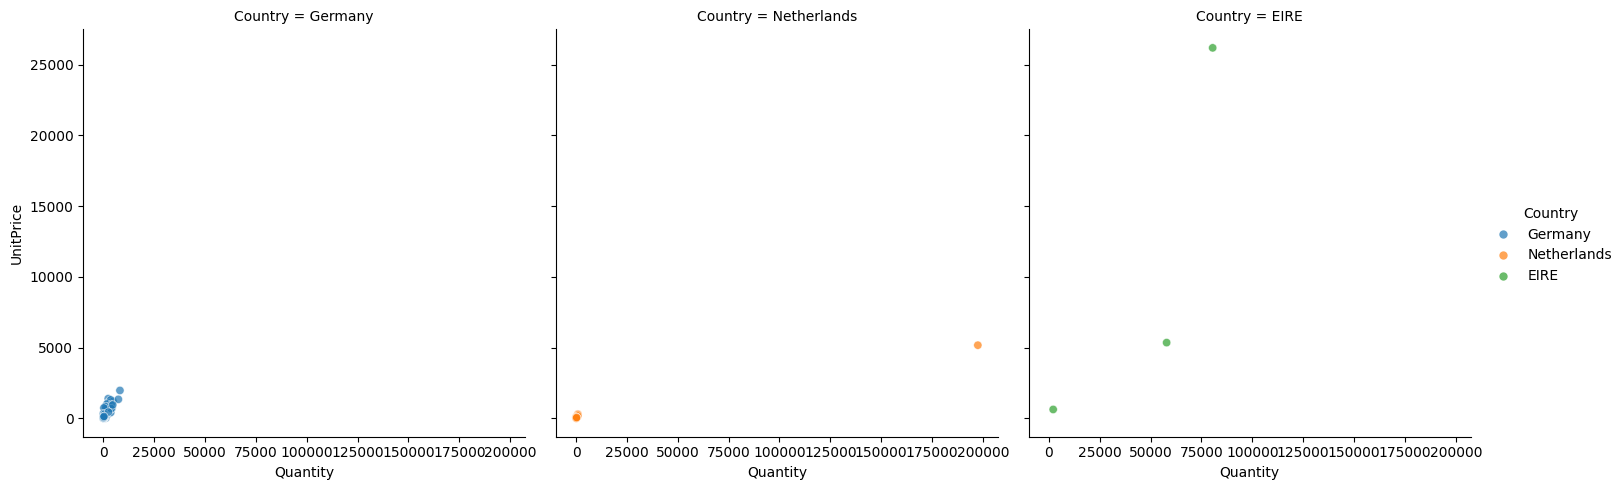

In [ ]:
import seaborn as sns


# Filtrar el DataFrame para incluir solo los países deseados
top_3 = df[df['Country'].isin(['Germany', 'EIRE', 'Netherlands'])]

top_3 = top_3.groupby(['CustomerID', 'Country']).agg({'Quantity': 'sum', 'UnitPrice': 'sum'}).reset_index()

# Crear el catplot
sns.relplot(
    data=top_3,
    x='Quantity',
    y='UnitPrice',
    hue='Country',  
    col='Country', 
    kind='scatter',
    alpha=0.7  
)


### Step 7. Investigate why the previous results look so uninformative.

This section might seem a bit tedious to go through. But I've thought of it as some kind of a simulation of problems one might encounter when dealing with data and other people. Besides there is a prize at the end (i.e. Section 8).

(But feel free to jump right ahead into Section 8 if you want; it doesn't require that you finish this section.)

#### Step 7.1 Look at the first line of code in Step 6. And try to figure out if it leads to any kind of problem.
##### Step 7.1.1 Display the first few rows of that DataFrame.

##### Step 7.1.2 Think about what that piece of code does and display the dtype of `UnitPrice`

##### Step 7.1.3 Pull data from `online_rt`for `CustomerID`s 12346.0 and 12347.0.

#### Step 7.2 Reinterpreting the initial problem.

To reiterate the question that we were dealing with:  
"Create a scatterplot with the Quantity per UnitPrice by CustomerID for the top 3 Countries"

The question is open to a set of different interpretations.
We need to disambiguate.

We could do a single plot by looking at all the data from the top 3 countries.
Or we could do one plot per country. To keep things consistent with the rest of the exercise,
let's stick to the latter oprion. So that's settled.

But "top 3 countries" with respect to what? Two answers suggest themselves:
Total sales volume (i.e. total quantity sold) or total sales (i.e. revenue).
This exercise goes for sales volume, so let's stick to that.

##### Step 7.2.1 Find out the top 3 countries in terms of sales volume.

##### Step 7.2.2 

Now that we have the top 3 countries, we can focus on the rest of the problem:  
"Quantity per UnitPrice by CustomerID".  
We need to unpack that.

"by CustomerID" part is easy. That means we're going to be plotting one dot per CustomerID's on our plot. In other words, we're going to be grouping by CustomerID.

"Quantity per UnitPrice" is trickier. Here's what we know:  
*One axis will represent a Quantity assigned to a given customer. This is easy; we can just plot the total  Quantity for each customer.  
*The other axis will represent a UnitPrice assigned to a given customer. Remember a single customer can have any number of orders with different prices, so summing up prices isn't quite helpful. Besides it's not quite clear what we mean when we say "unit price per customer"; it sounds like price of the customer! A reasonable alternative is that we assign each customer the average amount each has paid per item. So let's settle that question in that manner.

#### Step 7.3 Modify, select and plot data
##### Step 7.3.1 Add a column to online_rt called `Revenue` calculate the revenue (Quantity * UnitPrice) from each sale.
We will use this later to figure out an average price per customer.

##### Step 7.3.2 Group by `CustomerID` and `Country` and find out the average price (`AvgPrice`) each customer spends per unit.

##### Step 7.3.3 Plot

#### Step 7.4 What to do now?
We aren't much better-off than what we started with. The data are still extremely scattered around and don't seem quite informative.

But we shouldn't despair!
There are two things to realize:
1) The data seem to be skewed towaards the axes (e.g. we don't have any values where Quantity = 50000 and AvgPrice = 5). So that might suggest a trend.
2) We have more data! We've only been looking at the data from 3 different countries and they are plotted on different graphs.

So: we should plot the data regardless of `Country` and hopefully see a less scattered graph.

##### Step 7.4.1 Plot the data for each `CustomerID` on a single graph

##### Step 7.4.2 Zoom in so we can see that curve more clearly

### 8. Plot a line chart showing revenue (y) per UnitPrice (x).

Did Step 7 give us any insights about the data? Sure! As average price increases, the quantity ordered decreses.  But that's hardly surprising. It would be surprising if that wasn't the case!

Nevertheless the rate of drop in quantity is so drastic, it makes me wonder how our revenue changes with respect to item price. It would not be that surprising if it didn't change that much. But it would be interesting to know whether most of our revenue comes from expensive or inexpensive items, and how that relation looks like.

That is what we are going to do now.

#### 8.1 Group `UnitPrice` by intervals of 1 for prices [0,50), and sum `Quantity` and `Revenue`.

#### 8.3 Plot.

#### 8.4 Make it look nicer.
x-axis needs values.  
y-axis isn't that easy to read; show in terms of millions.

### BONUS: Create your own question and answer it.